In [1]:
from loader.Pouring_dataset import PouringText
from models.mmp import MMP, NRMMP
from models.modules import FC_SE32vec, FC_vec2SE3, vf_FC_vec, FC_vec

import matplotlib.pyplot as plt
import scipy, os, pickle
import torch
import copy

from IPython.display import clear_output
from tqdm import tqdm, trange
import time

from models.lfm import FlowMatching
device = f'cuda:0'
use_pretrained = True

In [2]:
encoder2 = FC_SE32vec(
    in_chan=480*12,
    out_chan=2,
    l_hidden=[2048, 1024, 512, 256, ],
    activation=['gelu', 'gelu', 'gelu', 'gelu',],
    out_activation='linear'
)
decoder2 = FC_vec2SE3(
    in_chan=2,
    out_chan=480*6,
    l_hidden=[256, 512, 1024, 2048, ],
    activation=['gelu', 'gelu', 'gelu', 'gelu',],
    out_activation='linear'
)
nrmmp = NRMMP(encoder2, decoder2, approx_order=1, kernel={'type': 'binary', 'lambda':0.1})
nrmmp.to(device)

load_dict = torch.load("results/nrmmp.pkl", map_location='cpu')
ckpt = load_dict["model_state"]
nrmmp.load_state_dict(ckpt)

<All keys matched successfully>

In [3]:
ds = PouringText(flatten_texts=True)
dl = torch.utils.data.DataLoader(ds, batch_size=10)

Pouring dataset is ready; # of trajectories: 10
PouringText dataset is ready; # of trajectories: 80


In [4]:
velocity_field = vf_FC_vec(
    in_chan=4+2+1, 
    out_chan=2, 
    l_hidden=[1024, 1024, ],
    activation=['gelu', 'gelu', ],
    out_activation='linear'
)
text_embedder = FC_vec(
    in_chan=768, 
    out_chan=4, 
    l_hidden=[1024, 1024, ],
    activation=['gelu', 'gelu', ],
    out_activation='linear'
)
lfm = FlowMatching(
    velocity_field,
    text_embedder,
    z_dim=2,
    mmp=nrmmp
)
lfm.to(device)

FlowMatching(
  (velocity_field): vf_FC_vec(
    (net): Sequential(
      (0): Linear(in_features=7, out_features=1024, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=1024, out_features=2, bias=True)
    )
  )
  (text_embedder): FC_vec(
    (net): Sequential(
      (0): Linear(in_features=768, out_features=1024, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=1024, out_features=4, bias=True)
    )
  )
  (mmp): NRMMP(
    (encoder): FC_SE32vec(
      (net): Sequential(
        (0): Linear(in_features=5760, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=1024, bias=True)
        (3): GELU(approximate='none')
        (4): Linear(in_features=1024, out_features=5

In [5]:
lfm.normalize(dl, device)

In [6]:
if use_pretrained:
    load_dict = torch.load("results/nrmmfp.pkl", map_location='cpu')
    ckpt = load_dict["model_state"]
    lfm.load_state_dict(ckpt)
    best_lfm= copy.copy(lfm)
else:
    opt = torch.optim.Adam(
        filter(lambda p: p.requires_grad, lfm.parameters()), 
        lr=0.0001,
        weight_decay=0.000001
    )
    # bset_mmd_avg = torch.inf
    best_val_loss = torch.inf
    for epoch in range(3000):
        for traj, text, label in dl:
            train_results = lfm.train_step(traj.to(device), text, optimizer=opt)
        if (epoch+1)%100==0:
            print(f"[Epoch: {epoch}] Loss: {train_results['loss']}")
        if (epoch+1)%500==0:
            val_loss = 0
            n = 0
            for _ in range(10):
                for traj, text, label in dl:
                    val_results = lfm.validation_step(traj.to(device), text)
                    val_loss += val_results['loss']
                    n += 1
            val_loss = val_loss/n
            print(f"[Epoch: {epoch}] Val Loss: {val_loss}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_lfm = copy.copy(lfm)
                print(f"bext_val_loss is updated to {best_val_loss}.")
            
        # if (epoch+1)%1000==0:
        #     eval_results = lfm.eval_step(dl, device)
        #     print_str = ""
        #     for key, item in eval_results.items():
        #         print_str += f"{key}: {item}"
        #     print(print_str) 
        #     mmd_avg = eval_results['mmd_avg_']
        #     if mmd_avg < bset_mmd_avg:
        #         bset_mmd_avg = mmd_avg
        #         best_lfm = copy.copy(lfm)
        #         print(f"bset_mmd_avg is updated to {bset_mmd_avg}.")
        
    torch.save({
        "model_state": best_lfm.state_dict()
    }, "results/nrmmfp.pkl")

In [7]:
encoded_data = nrmmp.encode(ds.traj_data_.to(device)).detach().cpu()
test_texts = [
    200*["Give me something to drink."],
    200*["Give me some water."],
    200*["Give me some wine."],
    200*["Give me some water, and pour it from the very right."],
    200*["Give me some wine, and pour it from the center."]
]
list_z_samples = []
for text in test_texts:
    list_z_samples.append(best_lfm.sample(
        text, 
        dt=0.1, 
        sample_z=True,
        guidance=1.5
        )[0].detach().cpu())

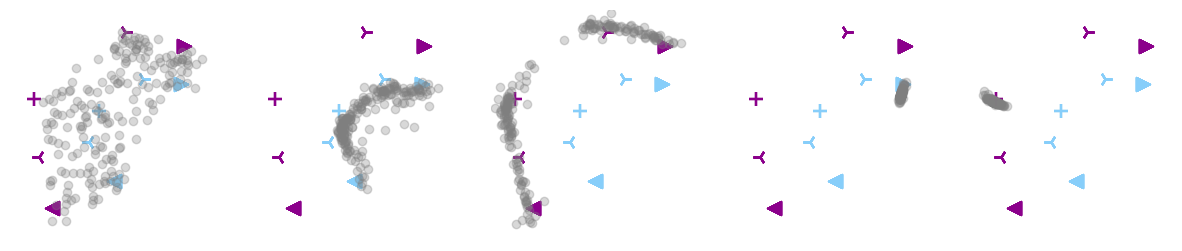

In [8]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# axs[0].set_title("Give me something to drink.")
# axs[1].set_title("Give me some water.")
# axs[2].set_title("Give me some wine.")
# axs[3].set_title("Give me some water, \n and pour it \n from the very right.")
# axs[4].set_title("Give me some wine, \n and pour it \n from the center.")

for i, z_samples in enumerate(list_z_samples):
    for z_data, l in zip(encoded_data, ds.labels_):
        if l[0] == 0:
            c = 'lightskyblue'
        else:
            c = 'darkmagenta'
        if l[1] == 0:
            s = 50
        else:
            s = 100
        if l[2] == 1:
            marker = '<'
        elif l[2] == 2:
            marker = '3'
        elif l[2] == 3:
            marker = '+'
        elif l[2] == 4:
            marker = '4'
        elif l[2] == 5:
            marker = '>'
        axs[i].scatter(z_data[0], z_data[1], s=s, c=c, marker=marker)
    axs[i].scatter(z_samples[:,0], z_samples[:,1], c='tab:gray', alpha=0.3)
    axs[i].axis('off')
    axs[i].set_xlim(-24, 8)
    axs[i].set_ylim(-16, 16)
plt.show()

In [9]:
test_texts = [
    200*["Give me something to drink."],
    200*["Give me some water."],
    200*["Give me some wine."],
    200*["Give me some water, and pour it from the very right."],
    200*["Give me some wine, and pour it from the center."]
]
list_z_trajs= []
for text in test_texts:
    list_z_trajs.append(best_lfm.sample(
        text, 
        dt=0.1, 
        sample_z=True,
        guidance=1.5,
        output_traj=True
        ).detach().cpu())

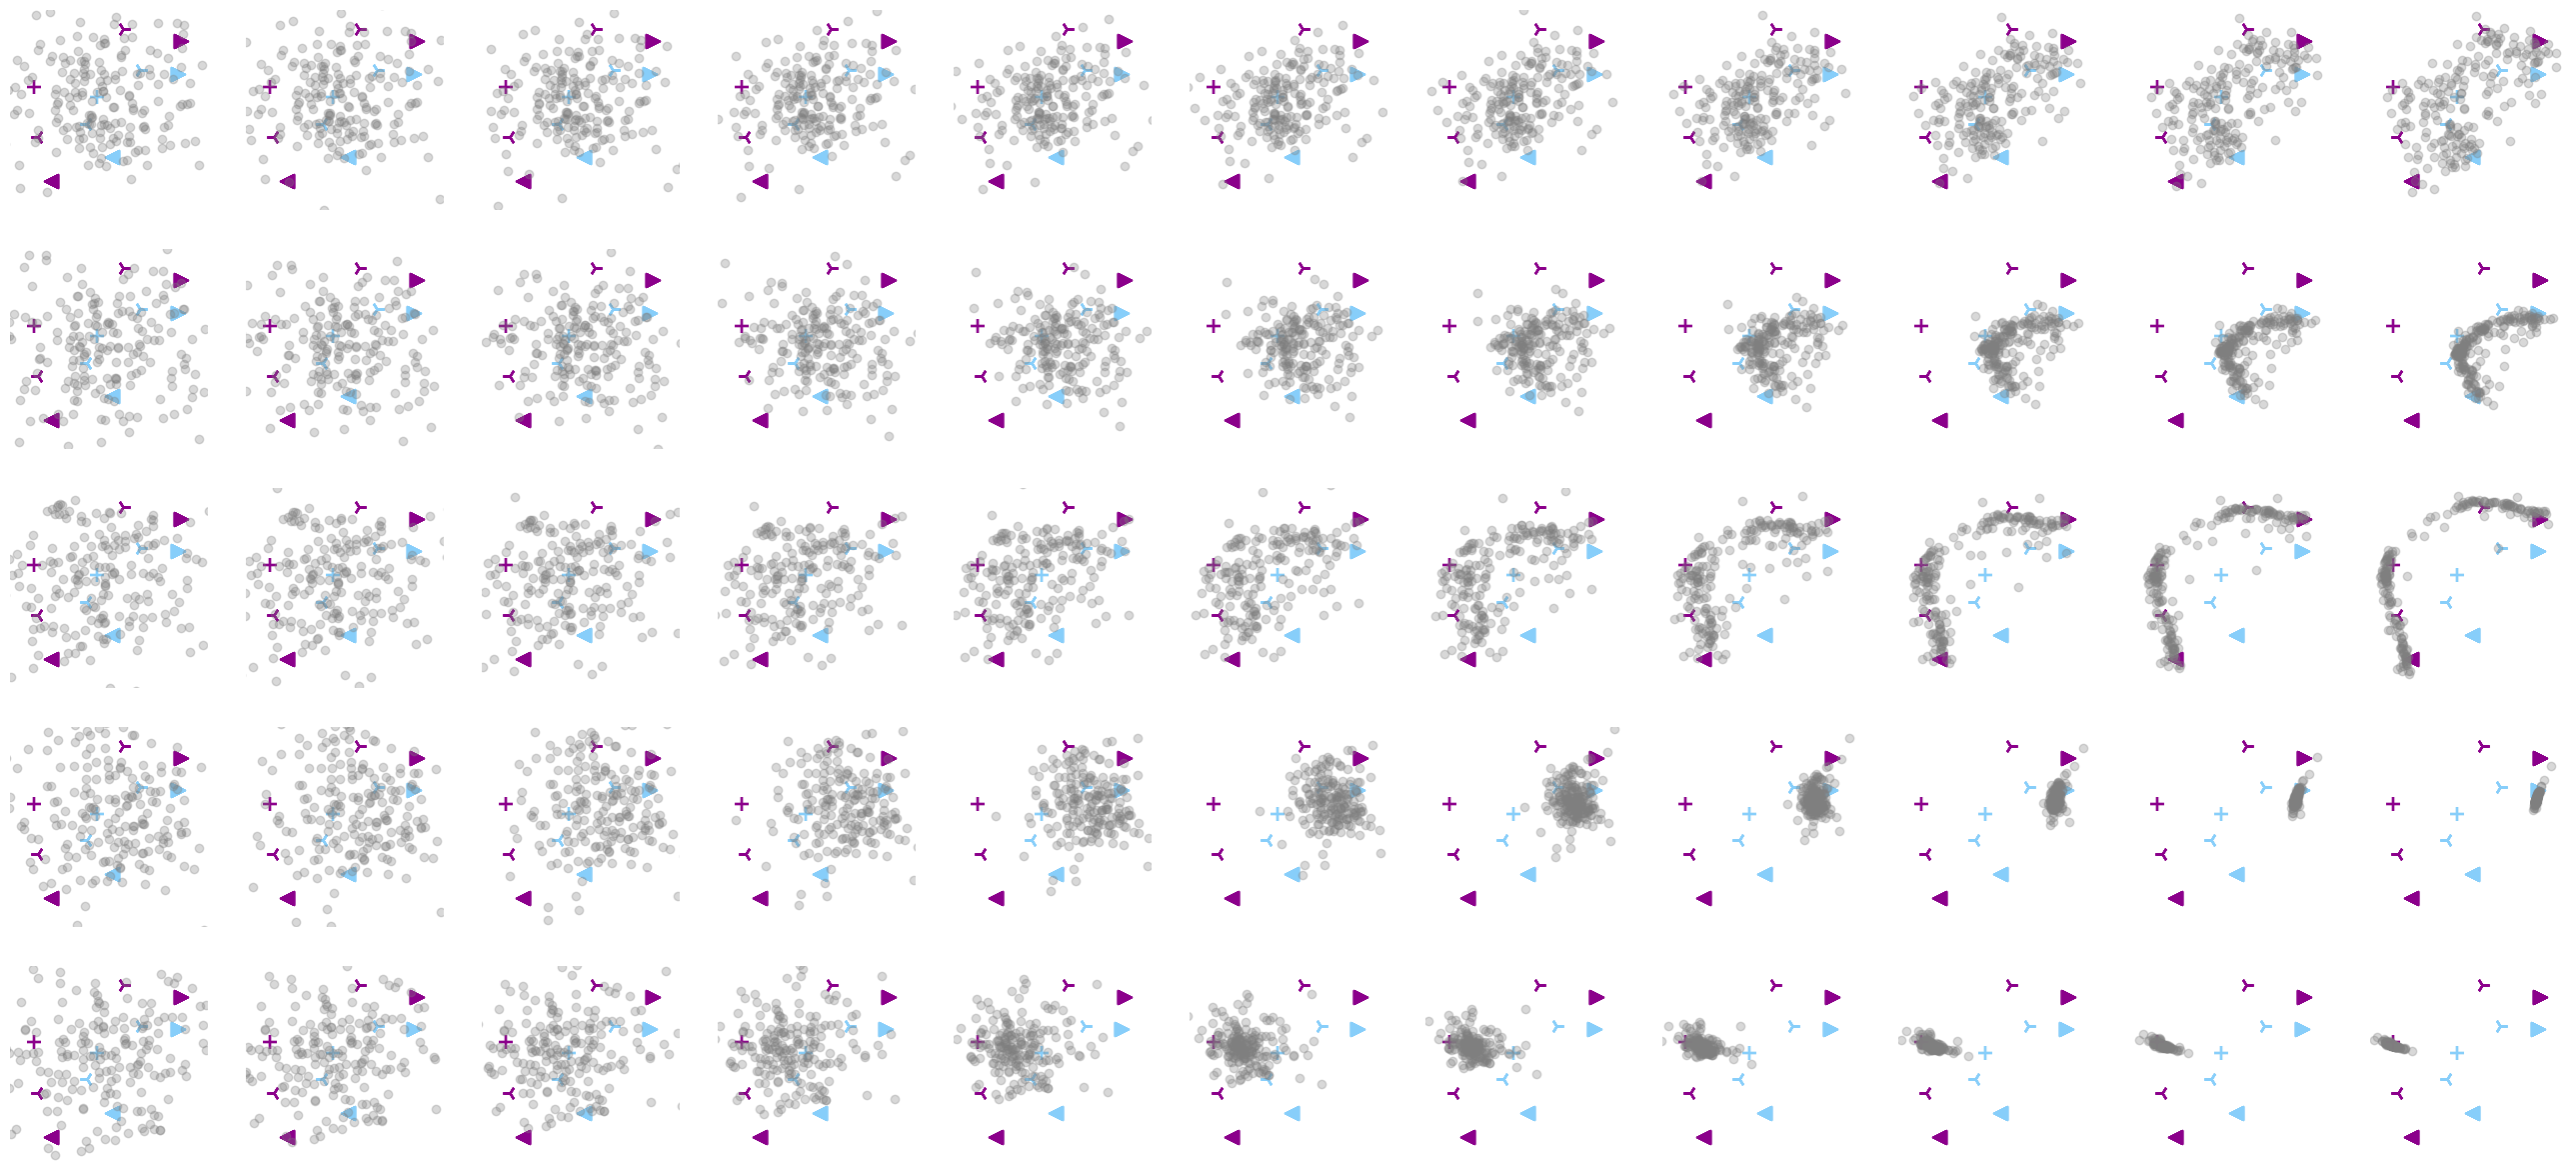

In [10]:
fig, axs = plt.subplots(5, 11, figsize=(33, 15))

for j, z_trajs in enumerate(list_z_trajs):
    for i, z_samples in enumerate(z_trajs.permute(1, 0, 2)):
        for z_data, l in zip(encoded_data, ds.labels_):
            if l[0] == 0:
                c = 'lightskyblue'
            else:
                c = 'darkmagenta'
            if l[1] == 0:
                s = 50
            else:
                s = 100
            if l[2] == 1:
                marker = '<'
            elif l[2] == 2:
                marker = '3'
            elif l[2] == 3:
                marker = '+'
            elif l[2] == 4:
                marker = '4'
            elif l[2] == 5:
                marker = '>'
            axs[j ,i].scatter(z_data[0], z_data[1], s=s, c=c, marker=marker)
        axs[j, i].scatter(z_samples[:,0], z_samples[:,1], c='tab:gray', alpha=0.3)
        axs[j, i].axis('off')
        axs[j, i].set_xlim(-24, 8)
        axs[j, i].set_ylim(-16, 16)
plt.show()